In [1]:
# Set local python and nltk paths
import sys
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/IPython/extensions')
sys.path
import nltk
nltk.data.path = ['/vol/medic02/users/ag6516/nltk_data']

In [2]:
import csv
import pandas as pd
import numpy as np
from read_data import read_csv_into_df
from vis_utils import kmeans_clustering, plot_pca, visualise_word_clusters2, kmeans_silhouette
from vis_utils import save_clusters_to_json, load_clusters_from_json

In [3]:
fields = ['Accession', 'Clinical history', 'Comment', 'Report text']
dir = ('/vol/medic02/users/ag6516/x_ray_fracture_localisation/')#
# dir = ('/Users/Aydan/PhD/x_ray_fracture_localisation/')

with open(dir + 'data/Reports/XKNEB_Jan_Dec_2015_anon.csv', 'rU') as csvfile:
    data1 = csv.reader(csvfile, delimiter=',')
    headers1 = data1.next()

with open(dir + 'data/Reports/XKNEB_Jan_Dec_2016_anon.csv', 'rU') as csvfile:
    data2 = csv.reader(csvfile, delimiter=',')
    headers2 = data2.next()

# with open(dir + 'data/Reports/XKNEB_Jan_Jul_2017_anon.csv', 'rU') as csvfile:
#     data3 = csv.reader(csvfile, delimiter=',')
#     headers3 = data3.next()

cols1 = [headers1.index(item) for item in fields]
cols2 = [headers2.index(item) for item in fields]
# cols3 = [headers3.index(item) for item in fields]

In [6]:
df1 = read_csv_into_df(dir + 'data/Reports/XKNEB_Jan_Dec_2015_anon.csv', fields, cols1)
df2 = read_csv_into_df(dir + 'data/Reports/XKNEB_Jan_Dec_2016_anon.csv', fields, cols2)

In [5]:
df = pd.concat([df1,df2])
print df.count()

Accession           3576
Clinical history    2232
Comment             2402
Report text         3576
dtype: int64


In [6]:
# Check for missing information
df_nans = df[df.isnull().any(axis=1)]
df_nans.to_csv('missing_info.csv', sep=',')

In [60]:
df.to_csv('cleaned_reports.csv', sep=',')

In [6]:
# Basic filtering and stats
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import random
random.seed(123)
np.random.seed(123)

reports = []
reports_tok = []
labels = []
words = []
for i, row in df.iterrows():
    report = row['Report text'].decode('utf-8').lower()
    
    # Remove markdown
    for char in ['\n', '\b', '~b']:
        report = report.replace(char, '')
    
    # Replace unnecessary punctuation 
    for char in ['~', '"']:
        report = report.replace(char, '')
        
    for char in ['!', '?', ';', ':', '.']:
        report = report.replace(char, ' . ')
    
    for char in ['(', ')', ',', '/']:
        report = report.replace(char, ' , ')
        
    # Tokenize
    report_tok = word_tokenize(report)
    
    # Remove stopwords
    filtered_report_tok = [word for word in report_tok if word not in stopwords.words('english')]
    filtered_report = ' '.join(filtered_report_tok)
    
    reports.append(filtered_report)
    reports_tok.append(filtered_report_tok)
    labels.append(row['Accession'])
    [words.append(word) for word in filtered_report_tok]

print 'Vocab length: ', len(sorted(set(words)))
print 'Avg no. of appearances: ', len(words)/len(sorted(set(words)))
fdist_all = nltk.FreqDist(words)
freqs = [freq for _, freq in fdist_all.most_common()]
print 'STD: ', np.std(freqs)
#print fdist_all.hapaxes()
print 'Number of reports: ', len(reports)

Vocab length:  1770
Avg no. of appearances:  51
STD:  387.079866728
Number of reports:  3576


Populating the interactive namespace from numpy and matplotlib
['.', 'knee', 'joint', 'xr', ',', 'medial', 'changes', 'degenerative', 'seen', 'space', 'right', 'patellofemoral', 'left', 'joints', 'change', 'compartment', 'previous', 'bilaterally', 'noted', 'loss', 'comparison', 'narrowing', 'spaces', 'compartments', 'tibiofemoral', 'mild', 'bilateral', 'osteophyte', 'imaging', 'bony', 'significant', 'moderate', 'osteophytosis', 'formation', 'within', 'lateral', 'made', 'knees', 'tibial', 'femoral', 'minor', 'osteoarthritic', 'marked', 'evidence', 'severe', 'preserved', 'acute', 'appearances', 'reduction', 'bone']


/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['char', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


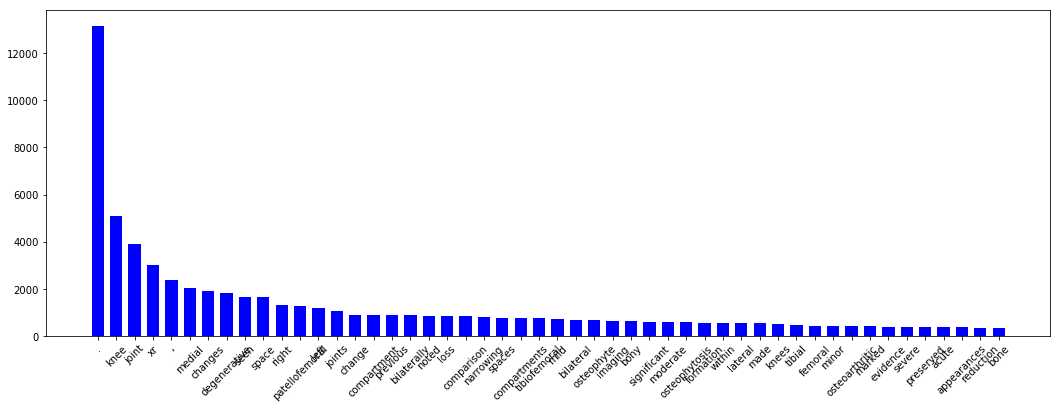

In [11]:
# Vocab stats
import matplotlib.pyplot as plt
#%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

hist = [(word,freq) for word, freq in fdist_all.most_common(50)]
#fdist_all.plot(50)

words = [str(word) for word in zip(*hist)[0]]
print words
counts = range(len(words))
frequency = zip(*hist)[1]

plt.bar(counts, frequency, 1/1.5, color="blue", align='center')
plt.xticks(counts, words, rotation=45)
fig = plt.gcf()

# 1. Doc2Vec
From the gensim library: doc2vec can be used to embed documents through a distributed memory and distributed bag of words approach (Mikolov 2014)

__[Quoc Le and Tomas Mikolov. Distributed Representations of Sentences and Documents](https://arxiv.org/pdf/1405.4053v2.pdf)__

In [7]:
# Generate Doc2Vec embeddings for reports
import gensim
from gensim.models.doc2vec import LabeledSentence

class DocIterator(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield LabeledSentence(words=doc, tags=[self.labels_list[idx]])
            
it = DocIterator(reports, labels)

## 1.1 Training doc2vec model
The model is trained on the entire text for 10 iterations

In [11]:
# Train model
model_d2v = gensim.models.Doc2Vec(size=300, min_count=0, alpha=0.025, min_alpha=0.025)
model_d2v.build_vocab(it)
#training of model
for epoch in range(10):
    print 'iteration ' +str(epoch+1)
    model_d2v.train(it, total_examples=model_d2v.corpus_count, epochs=model_d2v.iter)
    model_d2v.alpha -= 0.002
    model_d2v.min_alpha = model_d2v.alpha
    model_d2v.train(it, total_examples=model_d2v.corpus_count, epochs=model_d2v.iter)
#save the created model
model_d2v.save('doc2vec.model')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


In [8]:
# Or load pre-trained model
model_d2v = gensim.models.Doc2Vec.load('doc2vec.model')

## 1.2 Sampling report embeddings
We can test the embeddings by taking a sample of most simlar documents to a randomly sampled report

In [12]:
# Test model
pd.options.display.max_colwidth = 4000
label_sample = random.choice(labels)
report_sample = df.loc[df['Accession'] == label_sample]['Report text']
print "Sample document: \n"
print report_sample.to_string()

most_similar = model_d2v.docvecs.most_similar(label_sample)
print "\nMost similar documents: \n"

for label, _ in most_similar:
    print (df.loc[df['Accession'] == label]['Report text']).to_string()
    print ''

Sample document: 

349    XR Knee Both : \n\nLeft knee: There is severe OA change to the patellofemoral joint with less severe OA in the medial compartment of the knee joint. Alignment maintained.\n\nRight knee: TKR in situ. No previous images available for comparison. Good alignment. No adverse features.

Most similar documents: 

508    XR Knee Both : \n\nLeft knee: Unicompartment replacement of the medial joint. Good alignment. No adverse features.\n\nRight knee: TKR. Good alignment. No adverse features.

2538    XR Knee Both : Both knees have severe patellofemoral joint arthritis. And there is OA change in the medial compartment of the left knee joint causing a slight varus deformity.

3028    Both knees: There is severe degenerative change in the medial compartment of the left knee joint causing a varus angulation. There is similar but less severe change in the right knee joint.

3250    Left knee: Left TKR. Good alignment. No adverse features.\n\nRight knee: There is mild OA chan

## 1.3 Kmeans of doc2vec
The report embeddings can be grouped together using kmeans with a cluster size of 4. This is based on the assumption that we have 4 main pathologies present in the reports:
1. Osteoarthritis
2. Knee replacement
3. Fractures
4. No present pathologies

In [13]:
# Cluster documents using K-means
num_clusters_d2v = 4

# generate d2v embeddings
embeddings_d2v = []
for label in labels:
    embeddings_d2v.append(model_d2v.docvecs[label])

kmeans_labels_d2v = kmeans_clustering(embeddings_d2v, num_clusters_d2v)

In [42]:
# Save clusters to json
filename = 'kmeans_doc2vec1.json'
save_clusters_to_json(labels, reports, kmeans_labels_d2v, num_clusters_d2v, filename)

In [43]:
# Load clusters from json
clusters_d2v = load_clusters_from_json('kmeans_doc2vec1.json')

## 1.4 Wordclouds of Clusters
Wordclouds can be used to get an idea of the dominant words in each cluster

### Evaluation
Clusters are not distinct, each cluster contains reference to degeneration (a sign of OA)
1. Cluster 1 has a high occurance of femoral, tibial, lateral. 
2. Cluster 2 has a high occurance of medial, loss, OA
3. Cluster 3 has a high occurance of patellofemoral, tibiafemoral
4. Cluster 4 is a mix of the above

Reports in cluster2 869

Reports in cluster3 787

Reports in cluster0 921

Reports in cluster1 999



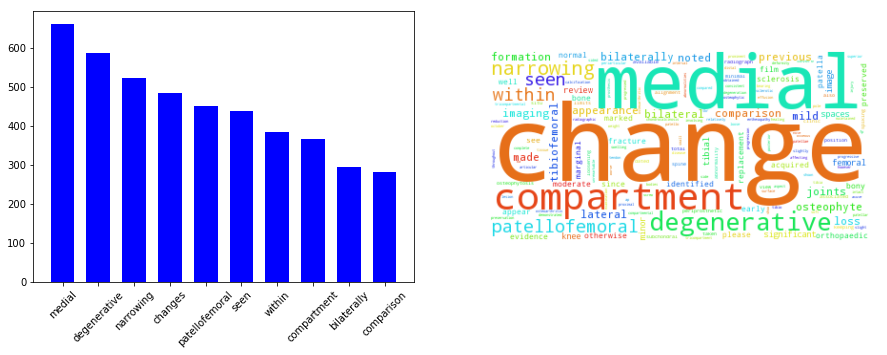

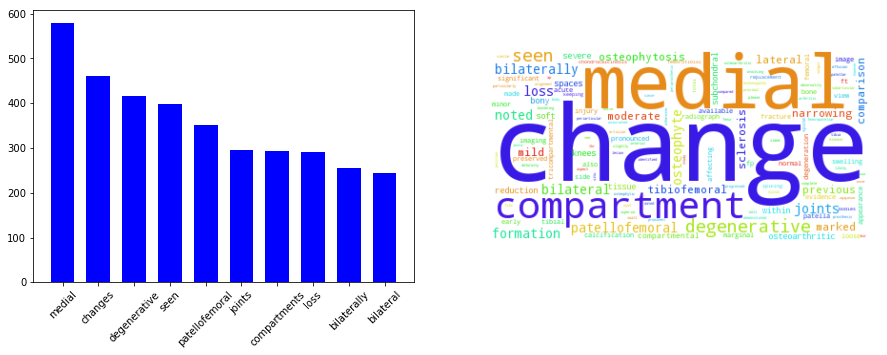

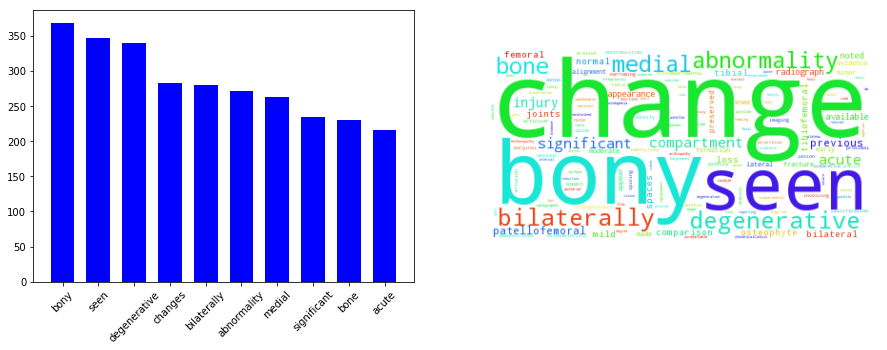

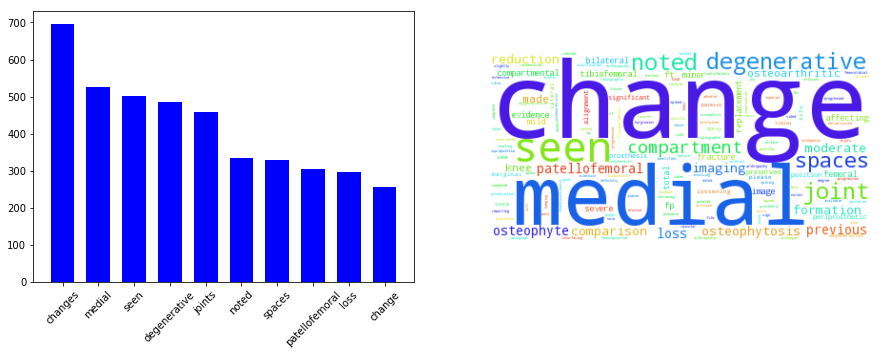

In [44]:
# Visualise words in clusters
%matplotlib inline
pd.options.display.max_colwidth = 4000

mystoplist = ['xr', 'knee', 'both', 'x-ray', 'joint', 'left', 'right', 'space', ':', '.', ',']
stoplist = mystoplist + stopwords.words('english')
visualise_word_clusters2(clusters_d2v, stoplist)

## 1.5 PCA of Clusters and Embeddings
The clustered report embeddings can be reduced using PCA to 2D and plotted. 

<IPython.core.display.Javascript object>


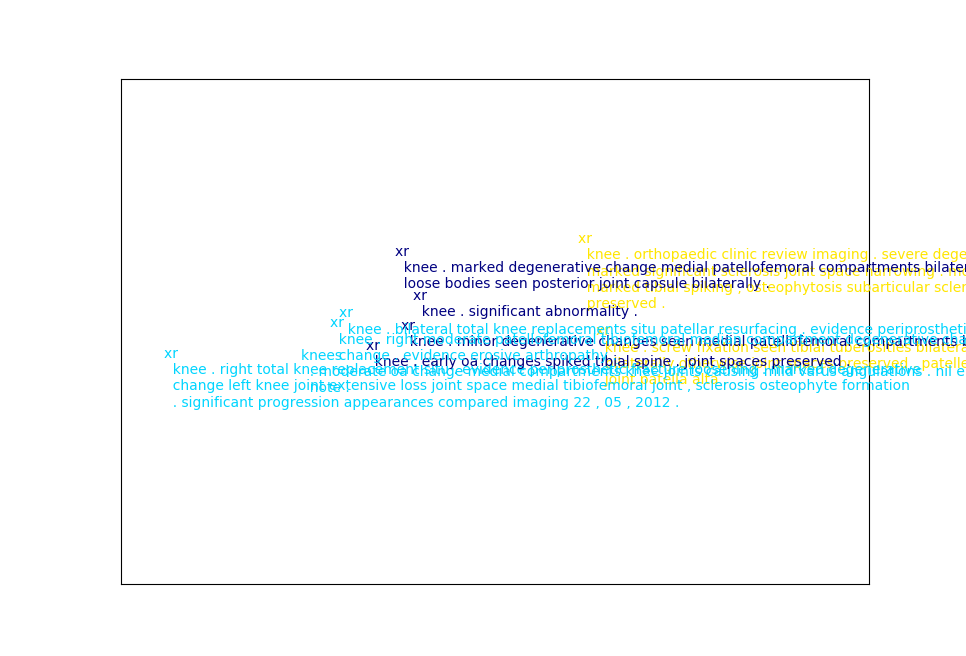

In [14]:
# Plot reports and clusters using PCA
# pylab.rcParams['figure.figsize'] = (18, 10)
pd.options.display.max_colwidth = 4000
%matplotlib notebook
%matplotlib notebook

# PCA
num_samples_pca = 10
reports_linebreaks = []
for report in reports:
    words = report.split()
    new_r = []
    for i, word in enumerate(words):
        new_r.append(word)
        if i%15==0:
            new_r.append(' \n ')
    reports_linebreaks.append(' '.join(new_r))

plot_pca(embeddings_d2v, reports_linebreaks, kmeans_labels_d2v, num_clusters_d2v, num_samples_pca)

# 2. InferSent
InferSent is a sentence embeddings method from Facebook, trained on natural language inference data.

__[Alexis Conneau et al. Supervised Learning of Universal Sentence Representations from Natural Language Inference Data](https://arxiv.org/abs/1705.02364)__

Encoder and trained models can be downloaded from here: __[InferSent](https://github.com/facebookresearch/InferSent)__

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint
import matplotlib
import torch
torch.set_num_threads(1)

GLOVE_PATH = dir + 'InferSent/GloVe/glove.840B.300d.txt'
print GLOVE_PATH

/vol/medic02/users/ag6516/x_ray_fracture_localisation/InferSent/GloVe/glove.840B.300d.txt


In [114]:
model_is = torch.load('infersent.allnli.pickle')
model_is.set_glove_path(GLOVE_PATH)

## 2.1 Create InferSent Embeddings
The InferSent model was trained using [GloVe](https://nlp.stanford.edu/projects/glove/) vectors, so words outside the glove vocab will not be encoded.

In [4]:
report_samples_is = reports[:10]

model_is.build_vocab(reports, tokenize=True)
embeddings_is = model_is.encode(reports, bsize=128, tokenize=True, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings_is)))

NameError: name 'reports' is not defined

## 2.2 Measure cosine similarity between report embeddings

In [123]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

report_sample1 = random.choice(reports)
print "Sample report 1: ", report_sample1

report_sample2 = random.choice(reports)
print "Sample report 2: ", report_sample2

print cosine(model_is.encode([report_sample1])[0], model_is.encode([report_sample2])[0])

Sample report 1:  xr knee . left knee right knee symptomatic . images compared previous 2013 . previous surgery noted . slight loss cartilage space medial compartment patellofemoral joint . alignment maintained . joanne hargreaves locum reporting radiographer ra28194
Sample report 2:  normal appearances right knee . evidence fracture dislocation . evidence intra-articular loose fragment . within left knee , ap view demonstrates small avulsed fragment arising medial tibial spine . mri advised evaluation .
0.873459


## 2.3 Visualise word importance

Populating the interactive namespace from numpy and matplotlib
Sample document: 

xr knee . moderate osteoarthritic changes seen knees tp tf joints loss joints spaces , osteophytosis bones osteopenic .


/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


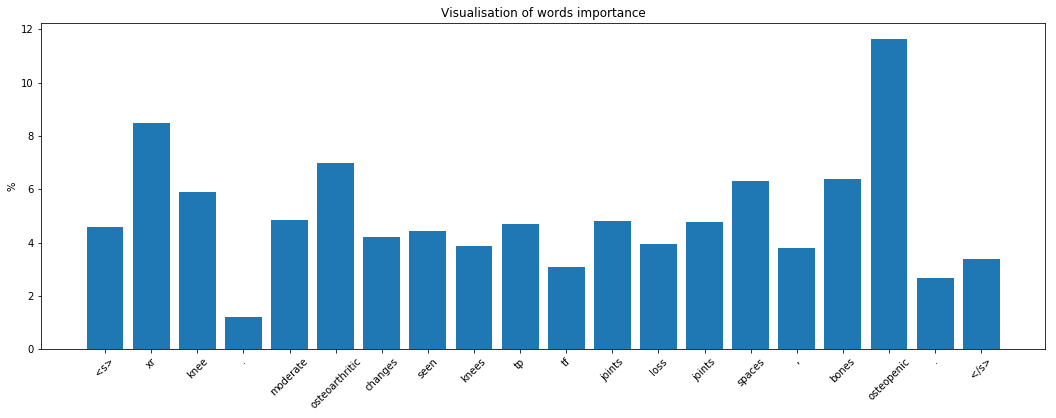

(Variable containing:
  4.0905e-02  2.9435e-02  2.8372e-01  ...   6.8168e-02 -1.1871e-02  6.2135e-03
 [torch.cuda.FloatTensor of size 1x4096 (GPU 0)],
 array([[ 7,  6, 13, ..., 16,  4,  2]]))

In [124]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

report_sample = random.choice(reports)
print "Sample document: \n"
print report_sample

model_is.visualize(report_sample, tokenize=True)

## 2.4 K-means silhouette evaluation
The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

2  clusters
12  clusters
22  clusters
32  clusters
42  clusters


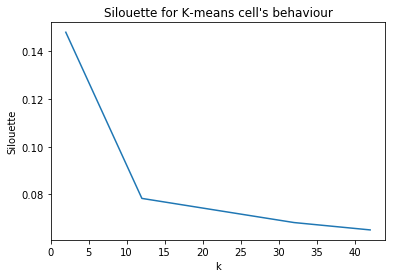

In [19]:
# Perform k-means on a range of k, evaluate silhouette
scores = kmeans_silhouette(embeddings_is, list(range(2,50,10)))

## 2.5 K-means of InferSent embeddings

In [19]:
# Cluster documents using K-means
num_clusters_is = 10

kmeans_labels_is = kmeans_clustering(embeddings_is, num_clusters_is)

In [27]:
# Save clusters into json
filename = 'kmeans_clusters_infersent3.json'
save_clusters_to_json(labels, reports, kmeans_labels_is, num_clusters_is, filename)

In [16]:
# Load clusters from json
clusters_is = load_clusters_from_json('kmeans_clusters_infersent3.json')

## 2.6 Wordclouds of Clusters

/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Reports in cluster8 112

Reports in cluster9 330

Reports in cluster2 325

Reports in cluster3 64

Reports in cluster0 649

Reports in cluster1 511

Reports in cluster6 283

Reports in cluster7 414

Reports in cluster4 580

Reports in cluster5 308



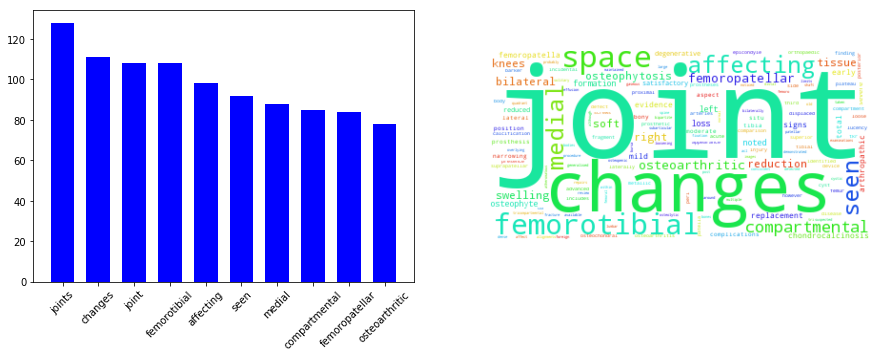

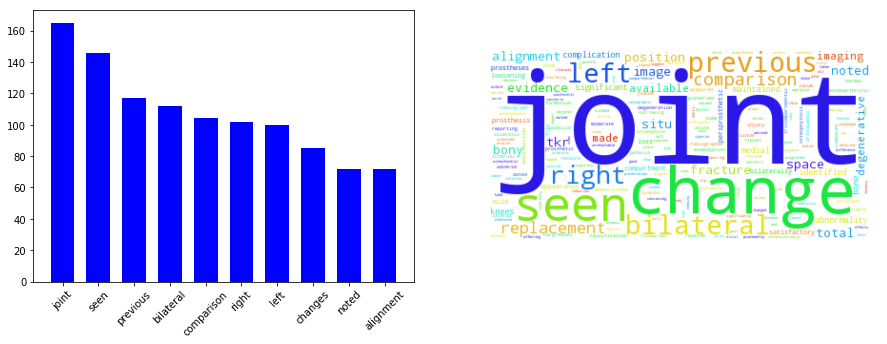

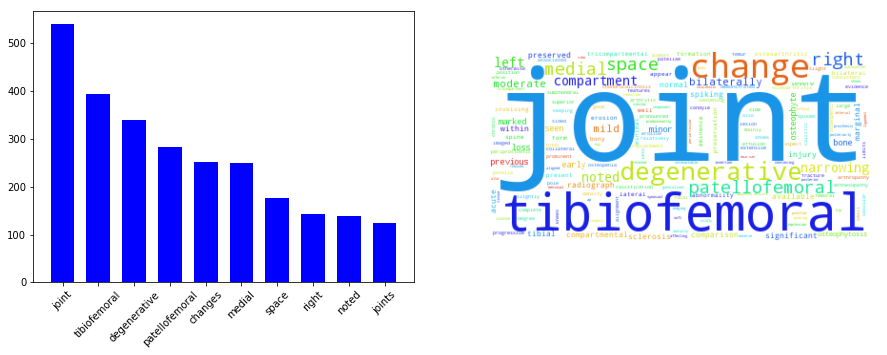

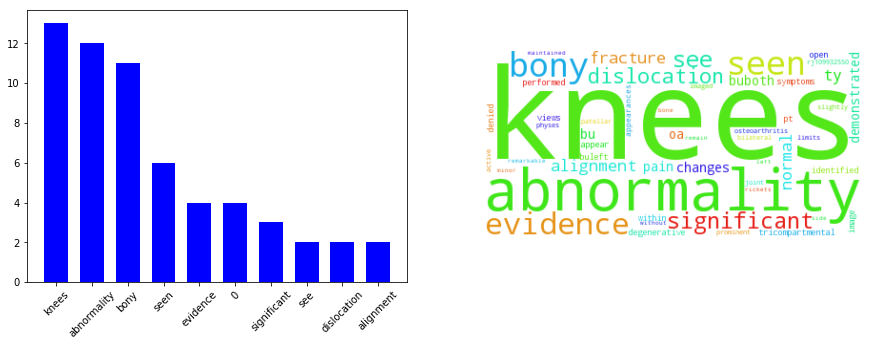

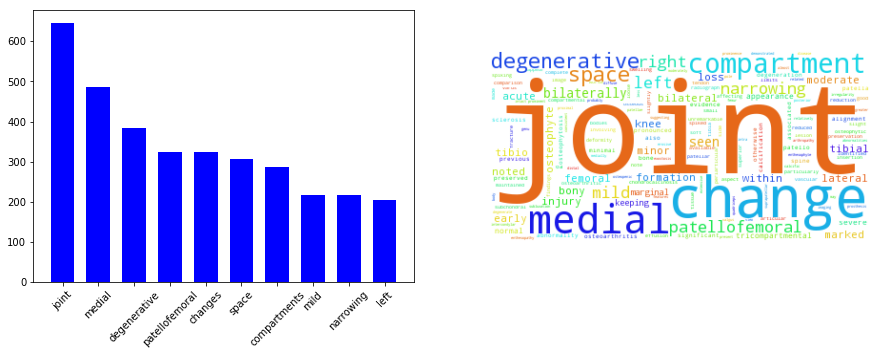

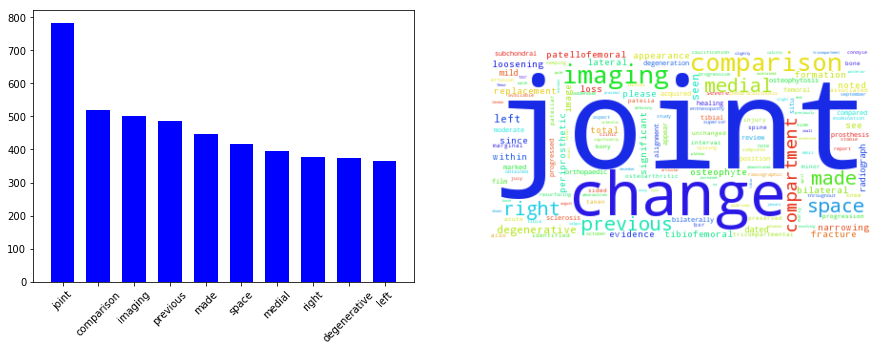

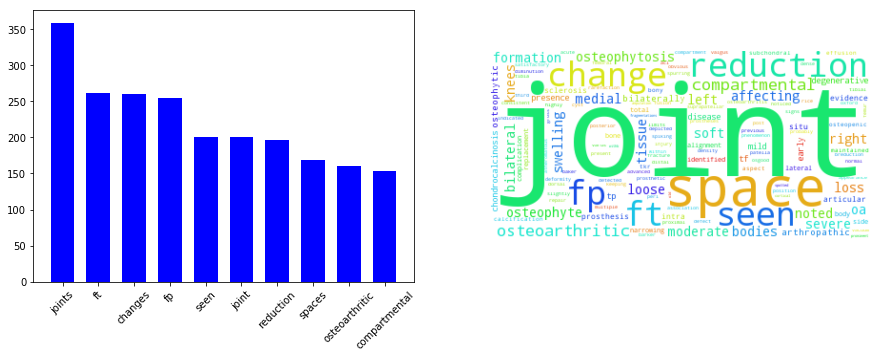

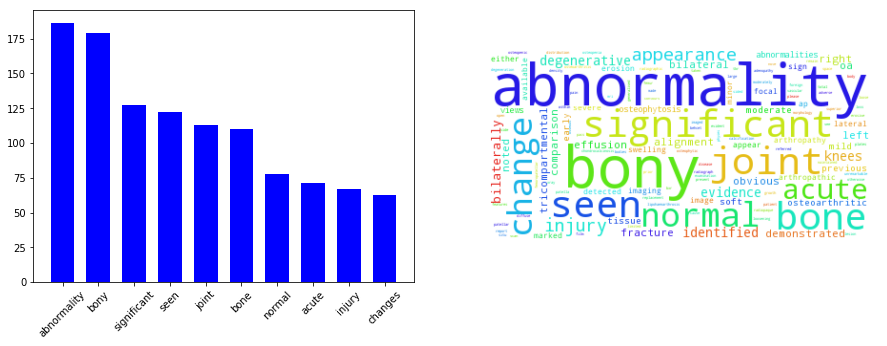

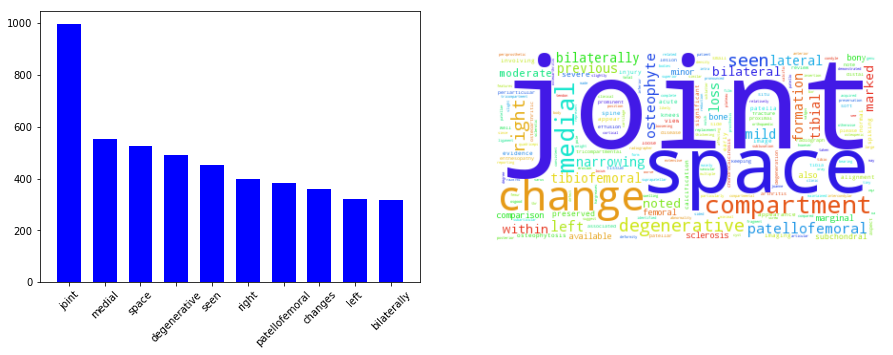

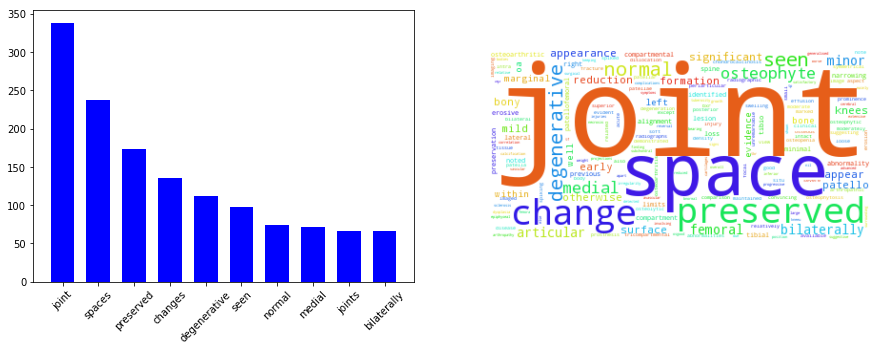

In [17]:
# Visualise words in clusters
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline

mystoplist = ['xr', 'knee', 'both', 'x-ray', ':', '.', ',']
stoplist = mystoplist + stopwords.words('english')

visualise_word_clusters2(clusters_is, stoplist)


## 2.7 PCA of clusters

<IPython.core.display.Javascript object>


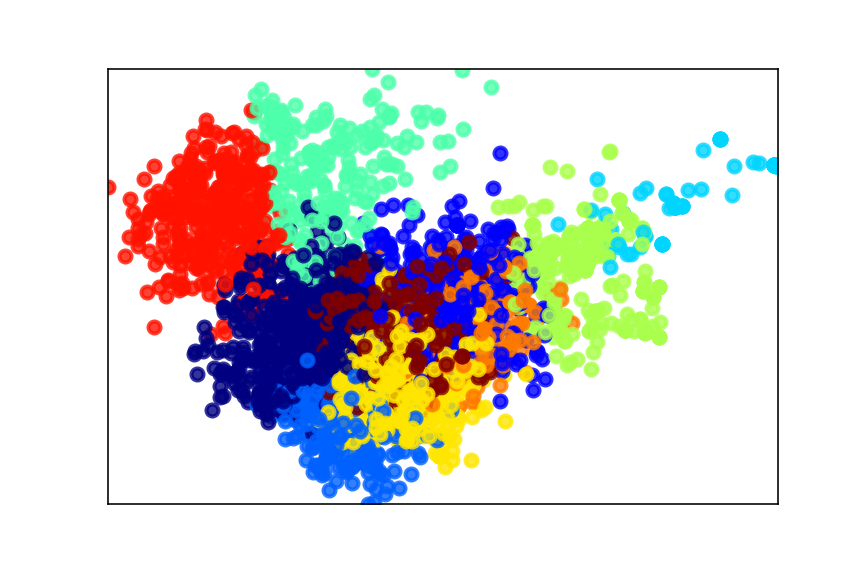

In [22]:
# Plot reports and clusters using PCA
#pylab.rcParams['figure.figsize'] = (18, 10)
pd.options.display.max_colwidth = 4000
%matplotlib notebook
%matplotlib notebook

num_samples_pca = len(reports)
report_samples_linebreaks = []
for report in reports:
    words = report.split()
    new_r = []
    for i, word in enumerate(words):
        new_r.append(word)
        if i%15==0:
            new_r.append(' \n ')
    report_samples_linebreaks.append(' '.join(new_r))

plot_pca(embeddings_is, report_samples_linebreaks, kmeans_labels_is, num_clusters_is, num_samples_pca, print_text=False)

## 2.8 Explore reports in clusters
1. __Cluster 0__ has a high occurance of the phrases *'comparison made'*, *'comparing previous'*, *'changes seen since'*; which suggests this cluster of reports all make reference to previous exams. Looking closely at the reports, it becomes clear that these phrases sometimes explicitly refer to a particular exam (such as *'comparison made images dated 14 , 05 , 2015'*), but sometimes implicitly (*'appearances progressed significantly since 2013'*). However, all the reports make reference to time (year or date)

2. __Cluster 1__ has a high occurance of empty reports, and reports with the word 'abnormality'

3. __Cluster 2__ has a high occurance of words *'mild'*, *'moderate'*, *'minor'*, *'early'* when referring to *'degenerative change'*

4. __Cluster 3__ has a high occurance of the phrases *'osteoarthritic changes'*, *'joints osteophyte formations'* and *'reduction joint space'*

5. __Cluster 4__ has a high occurance of the word *'bony'* as an adjective for *'abnormality'* and *'normal appearance'*

6. __Cluster 5__ has a high occurance of the word *'prosthesis'*

7. __Cluster 6__ is a collection of the longest reports with a combination of pathologies

8. __Cluster 7__ has a high occurance of the phrase *'joint space'*

9. __Cluster 8__ also has a high occurance of the phrases *'comparison made'* and *'previous images'*, however, most do not contain any references to specific dates/years

10. __Cluster 9__ also a collection of long reports with many pathologies, but most (if not all) contain the phrases *'comparison made'* with references to specific dates/years

# 3. Higher level filtering
Phrases that compare previous images are not particularly helpful in determining relevant image-features-text correspondance of this particular exam (unless we have access to the previous exams). Since we do not, these phrases can be filtered out.
In addition, reports with no words can be filtered out.

In [64]:
import re

hl_filtered_reports = []
for report in reports:
    # filter out 'comparison' + dates
    re.sub('( compar.*?\d{4})', '', report)
    re.sub('(xr knee both)', '', report)
    re.sub('(xr knee)', '', report)
    hl_filtered_reports.append(report)


## 3.1 Re-clustering filtered reports

Nb words kept : 97107/98907 (98.18 %)
Speed : 455.59 sentences/s (gpu mode, bsize=128)
nb sentences encoded : 3576


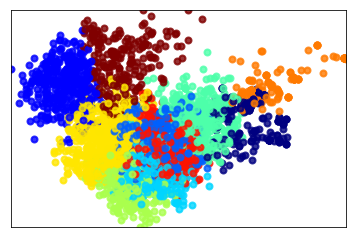

In [65]:
# Generate new InferSent embeddings
new_embeddings_is = model_is.encode(hl_filtered_reports, bsize=128, tokenize=True, verbose=True)
print('nb sentences encoded : {0}'.format(len(new_embeddings_is)))

# Cluster documents using K-means
num_clusters_is = 10
new_kmeans_labels_is = kmeans_clustering(new_embeddings_is, num_clusters_is)

# PCA
num_samples_pca = len(new_embeddings_is)
plot_pca(new_embeddings_is, reports_linebreaks, new_kmeans_labels_is, num_clusters_is, num_samples_pca, print_text=False)

In [66]:
# Save new clusters to json
filename = 'kmeans_clusters_filtered_infersent.json'
save_clusters_to_json(labels, reports, kmeans_labels_is, num_clusters_is, filename)

In [67]:
# Load clusters from json
clusters_is_fil = load_clusters_from_json('kmeans_clusters_filtered_infersent.json')

Reports in cluster8 112

Reports in cluster9 330

Reports in cluster2 325

Reports in cluster3 64

Reports in cluster0 649

Reports in cluster1 511

Reports in cluster6 283

Reports in cluster7 414

Reports in cluster4 580

Reports in cluster5 308



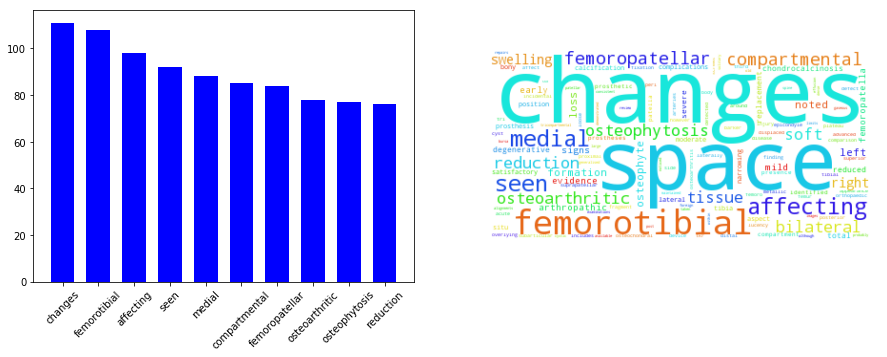

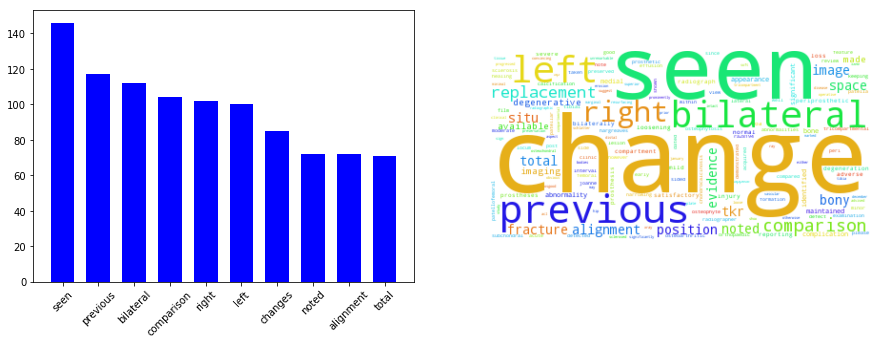

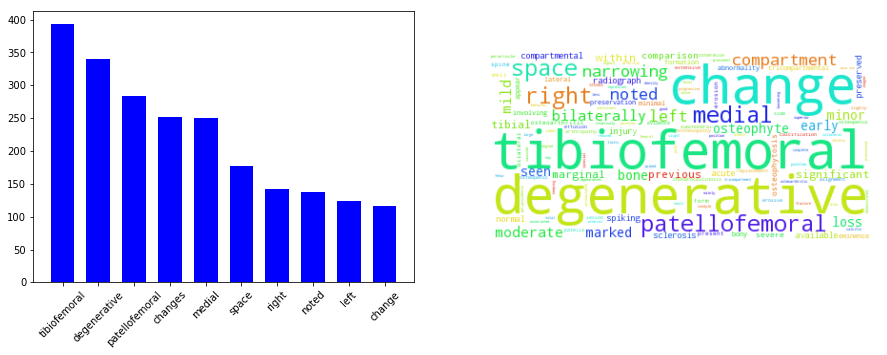

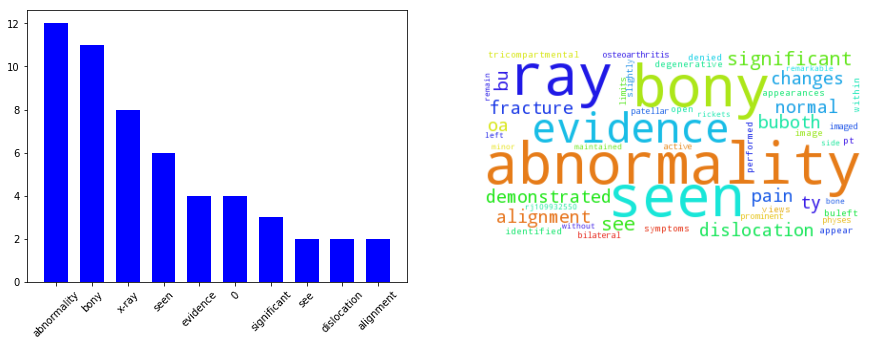

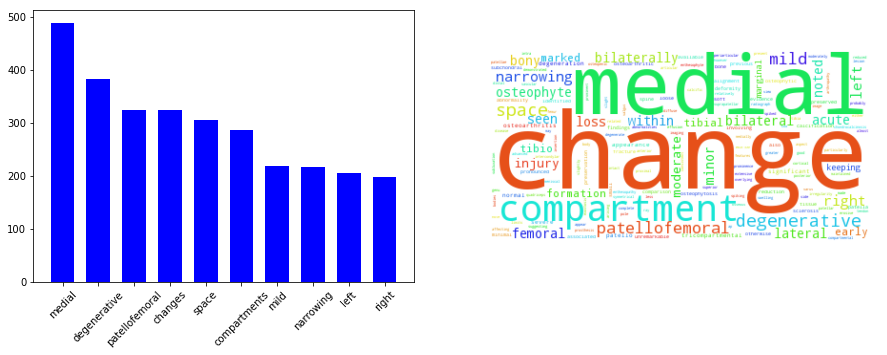

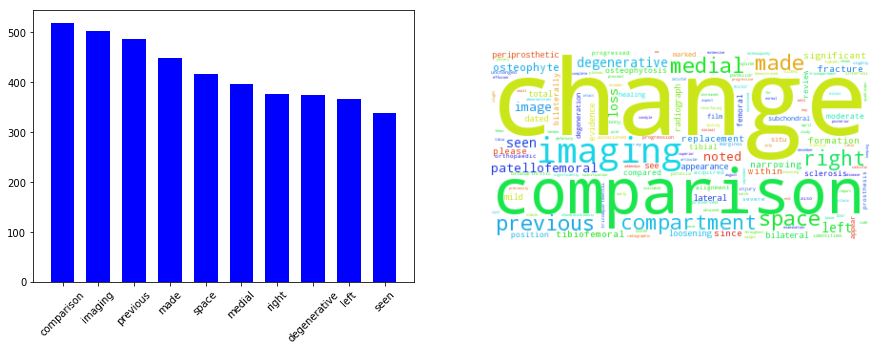

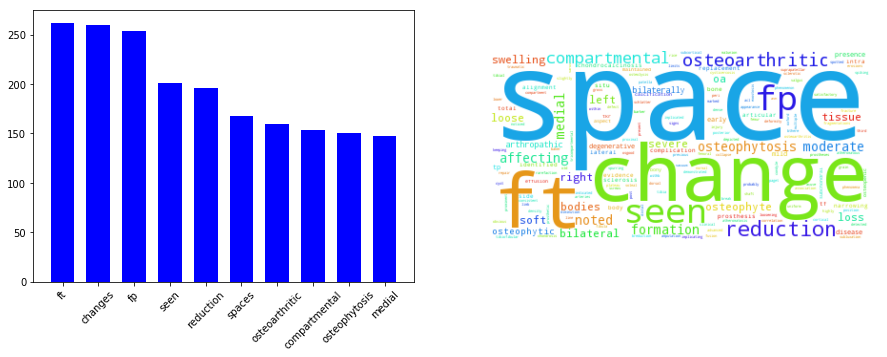

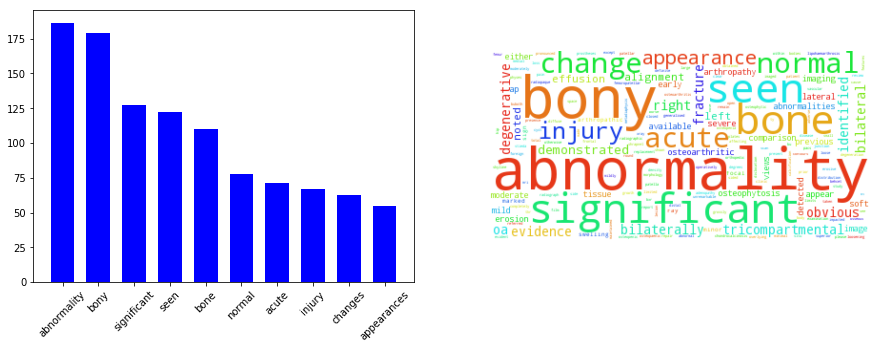

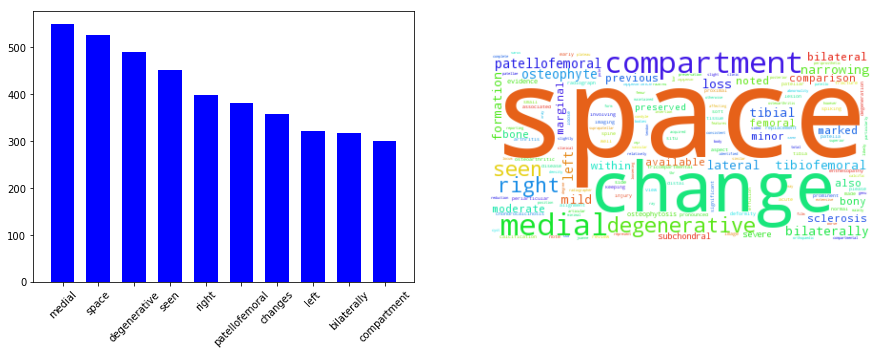

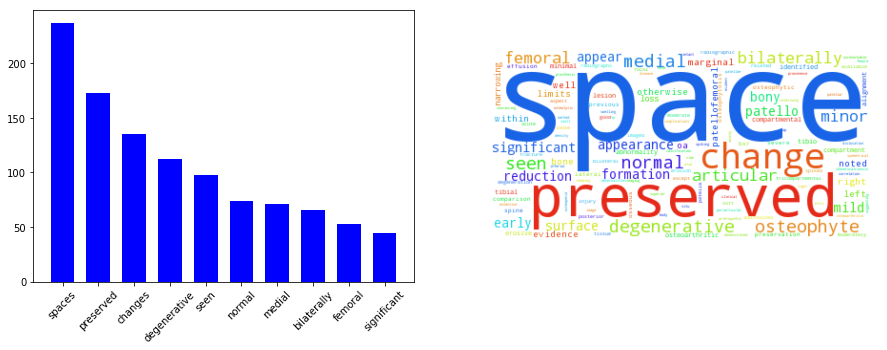

In [68]:
%matplotlib inline

mystoplist = [':', '.', ',', 'knee', 'knees', 'xr', 'joint', 'joints']
stoplist = mystoplist + stopwords.words('english')

visualise_word_clusters2(clusters_is_fil, stoplist)

In [69]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(clusters_is_fil['cluster3'])

{   u'RJ109665091': u'knee x-ray',
    u'RJ109666483': u'bony abnormality seen',
    u'RJ109687073': u'significant bony abnormality identified',
    u'RJ109687197': u'x-ray knees',
    u'RJ109691767': u'xr knee . .',
    u'RJ109702593': u'xr knee . see',
    u'RJ109703992': u'xr knee . see',
    u'RJ109724355': u'evidence fracture dislocation .',
    u'RJ109729749': u'bony abnormality',
    u'RJ109736514': u'x-ray knees',
    u'RJ109740202': u'imaged - pt denied symptoms',
    u'RJ109742321': u'x-ray knees',
    u'RJ109743205': u'0',
    u'RJ109743526': u'0',
    u'RJ109753227': u'x-ray knees',
    u'RJ109753887': u'0',
    u'RJ109756769': u'bony abnormality seen',
    u'RJ109764381': u'x-ray knees',
    u'RJ109765654': u'x-ray knees',
    u'RJ109793573': u'bony abnormality',
    u'RJ109799610': u'evidence fracture dislocation .',
    u'RJ109801027': u'significant bony abnormality seen',
    u'RJ109802781': u'. .',
    u'RJ109806007': u'knees',
    u'RJ109813348': u'xr knee .',
    u'R

Smallest cluster contains reports with little or no text. Going back to the original csv, it looks like some reports were not extracted correctly, whilst others did indeed have no text. The ones with no text can be removed, and the ones that were not extracted correctly were manually edited in.

## 3.2 Clean reports, filter and re-cluster

In [6]:
df_new = pd.read_csv(dir + 'cleaned_reports_edited.csv')

In [7]:
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import random
random.seed(123)
np.random.seed(123)

reports_cl = []
reports_tok_cl = []
labels_cl = []
words_cl = []

for i, row in df_new.iterrows():
    report = row['Report text'].decode('utf-8').lower()
    
    # Remove markdown
    for char in ['\n', '\b']:
        report = report.replace(char, '')
    
    # Replace unnecessary punctuation 
    for char in ['~', '"']:
        report = report.replace(char, '')
        
    for char in ['!', '?', ';', ':', '.']:
        report = report.replace(char, ' . ')
    
    for char in ['(', ')', ',', '/']:
        report = report.replace(char, ' , ')
        
    # filter out 'comparison' + dates
    report = re.sub('( compar.*?\d{4})', '', report)
    report = re.sub('(xr knee both)', '', report)
    report = re.sub('(xr knee)', '', report)
        
    # Tokenize
    report_tok = word_tokenize(report)
    
    # Remove stopwords
    filtered_report_tok = [word for word in report_tok if word not in stopwords.words('english')]
    filtered_report = ' '.join(filtered_report_tok)
    
    reports_cl.append(filtered_report)
    reports_tok_cl.append(filtered_report_tok)
    labels_cl.append(row['Accession'])
    [words_cl.append(word) for word in filtered_report_tok]

print 'Vocab length: ', len(sorted(set(words_cl)))
print 'Avg no. of appearances: ', len(words_cl)/len(sorted(set(words_cl)))
fdist_all = nltk.FreqDist(words_cl)
freqs = [freq for _, freq in fdist_all.most_common()]
print 'STD: ', np.std(freqs)
#print fdist_all.hapaxes()
print 'Number of reports: ', len(reports_cl)

Vocab length:  1793
Avg no. of appearances:  44
STD:  351.989764732
Number of reports:  3561


Populating the interactive namespace from numpy and matplotlib
['.', 'joint', 'medial', 'changes', ',', 'degenerative', 'knee', 'seen', 'space', 'patellofemoral', 'right', 'left', 'joints', 'change', 'bilaterally', 'noted', 'loss', 'compartment', 'narrowing', 'spaces', 'tibiofemoral', 'previous', 'mild', 'compartments', 'bilateral', 'osteophyte', 'bony', 'moderate', 'osteophytosis', 'significant', 'within', 'formation', 'lateral', 'knees', 'comparison', 'tibial', 'femoral', 'minor', 'osteoarthritic', 'imaging', 'marked', 'evidence', 'severe', 'preserved', 'acute', 'reduction', 'injury', 'bone', 'normal', 'abnormality']


/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['char', 'randint', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


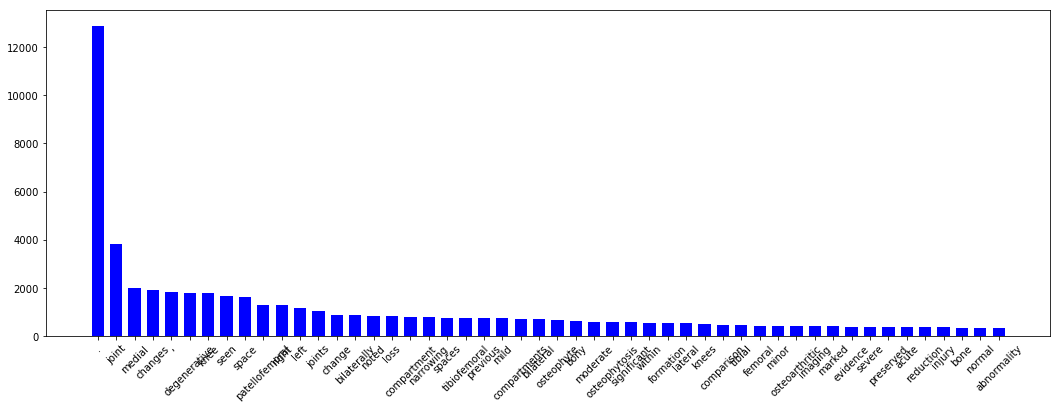

In [8]:
# Vocab stats
import matplotlib.pyplot as plt
#%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

hist = [(word,freq) for word, freq in fdist_all.most_common(50)]
#fdist_all.plot(50)

words = [str(word) for word in zip(*hist)[0]]
print words
counts = range(len(words))
frequency = zip(*hist)[1]

plt.bar(counts, frequency, 1/1.5, color="blue", align='center')
plt.xticks(counts, words, rotation=45)
fig = plt.gcf()

In [9]:
# Generate new InferSent embeddings
model_is_new = torch.load('infersent.allnli.pickle')
model_is_new.set_glove_path(GLOVE_PATH)

model_is_new.build_vocab(reports_cl, tokenize=True)
embeddings_is_cl = model_is_new.encode(reports_cl, bsize=128, tokenize=True, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings_is_cl)))

/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Found 1530(/1795) words with glove vectors
Vocab size : 1530
Nb words kept : 85638/87691 (97.66 %)


models.py:53: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid


Speed : 478.64 sentences/s (gpu mode, bsize=128)
nb sentences encoded : 3561


2  clusters
12  clusters
22  clusters
32  clusters
42  clusters


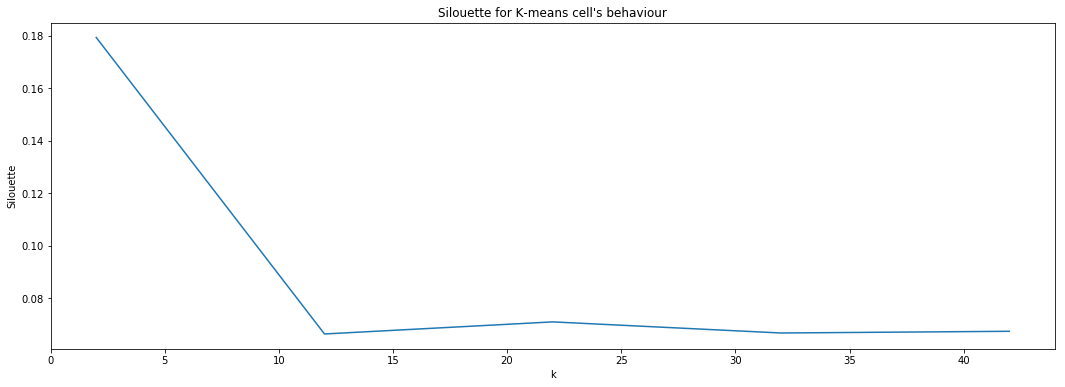

In [11]:
# Perform k-means on a range of k, evaluate silhouette
scores = kmeans_silhouette(embeddings_is_cl, list(range(2,50,10)))

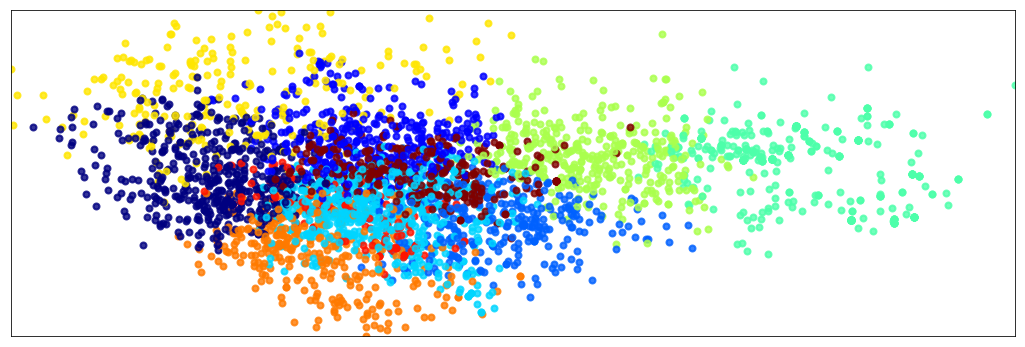

In [12]:
# Cluster documents using K-means
num_clusters_is = 10
kmeans_labels_is_cl = kmeans_clustering(embeddings_is_cl, num_clusters_is)

# PCA
reports_linebreaks_cl = []
for report in reports_cl:
    words = report.split()
    new_r = []
    for i, word in enumerate(words):
        new_r.append(word)
        if i%15==0:
            new_r.append(' \n ')
    reports_linebreaks_cl.append(' '.join(new_r))
    
num_samples_pca = len(embeddings_is_cl)
plot_pca(embeddings_is_cl, reports_linebreaks_cl, kmeans_labels_is_cl, num_clusters_is, num_samples_pca, print_text=False)

In [13]:
# Save new clusters to json
filename = 'kmeans_clusters_cleaned_filtered_infersent.json'
save_clusters_to_json(labels_cl, reports_cl, kmeans_labels_is_cl, num_clusters_is, filename)

In [14]:
# Load clusters from json
clusters_is_cl = load_clusters_from_json('kmeans_clusters_cleaned_filtered_infersent.json')

/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Reports in cluster8 112

Reports in cluster9 291

Reports in cluster2 308

Reports in cluster3 619

Reports in cluster0 466

Reports in cluster1 425

Reports in cluster6 246

Reports in cluster7 345

Reports in cluster4 370

Reports in cluster5 379



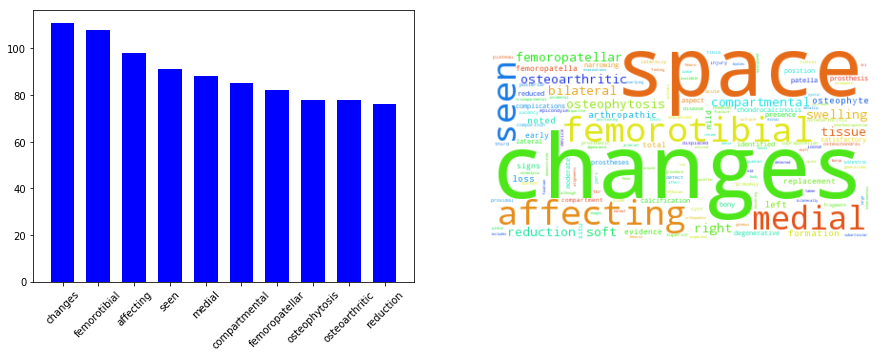

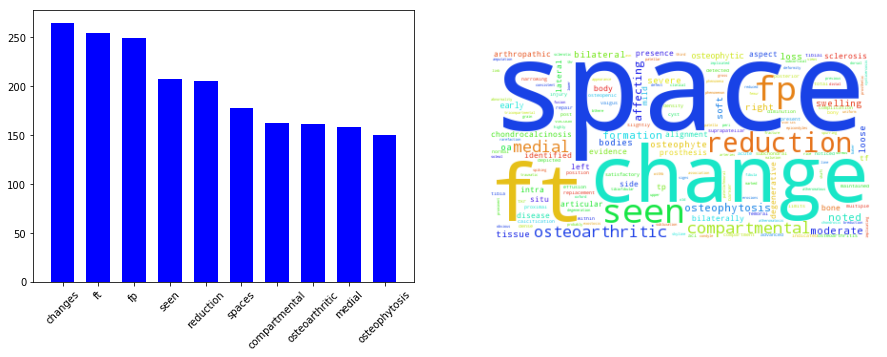

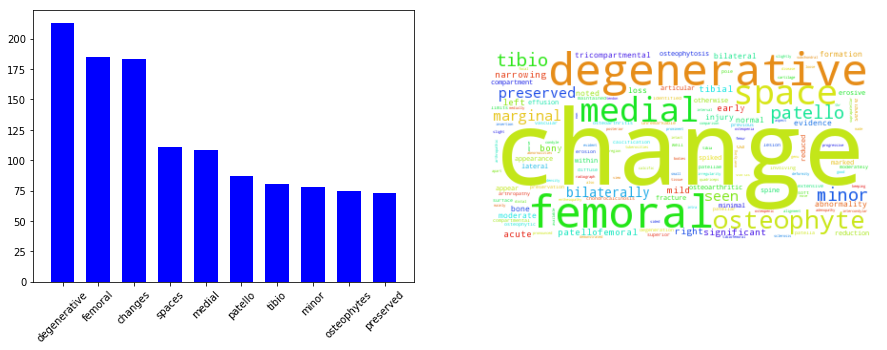

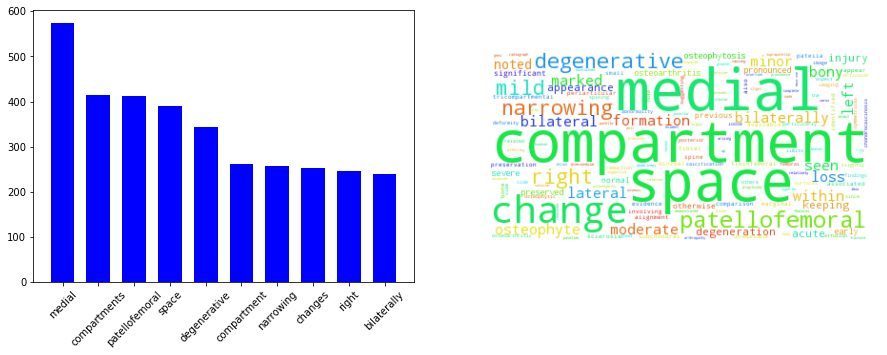

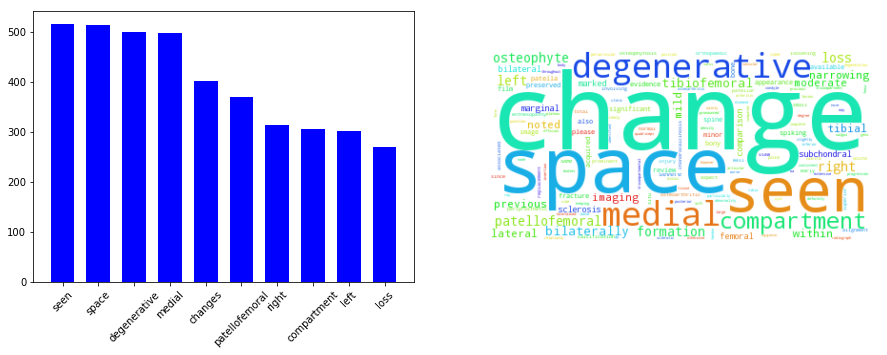

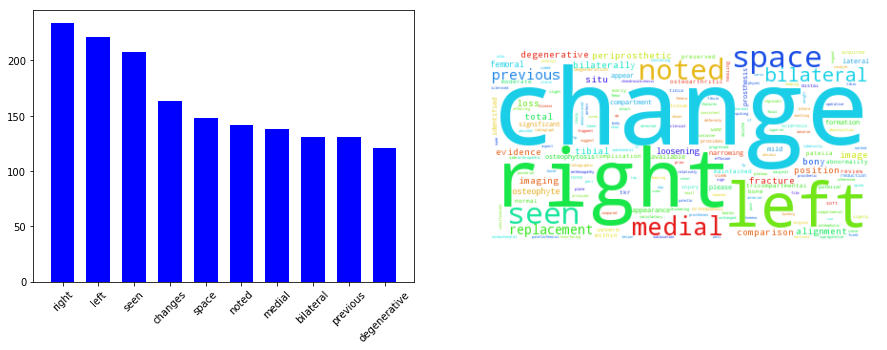

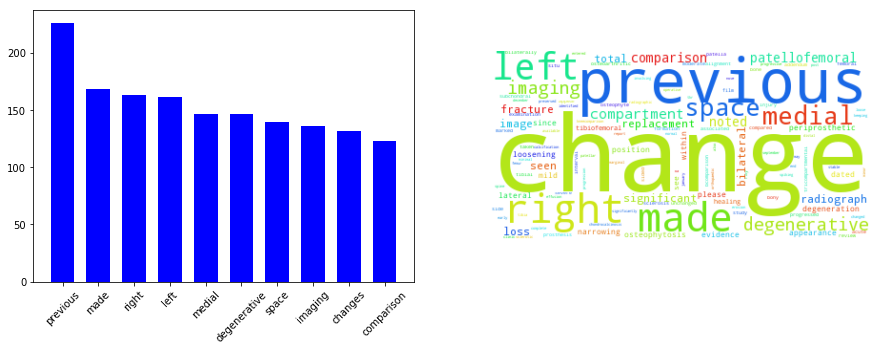

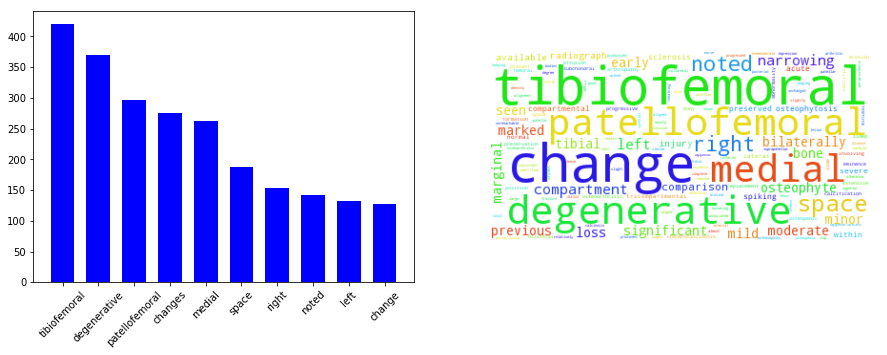

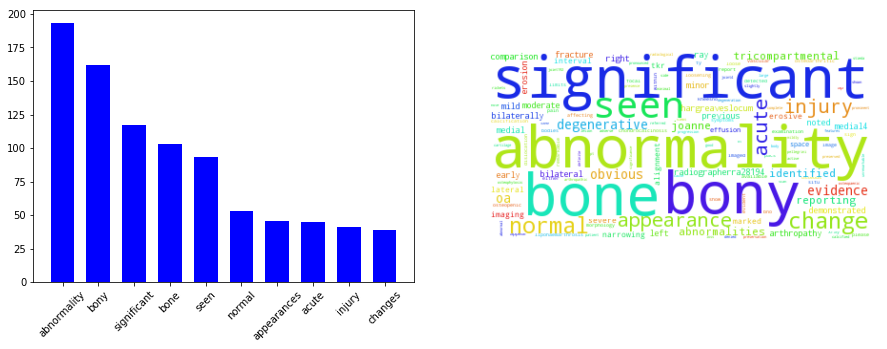

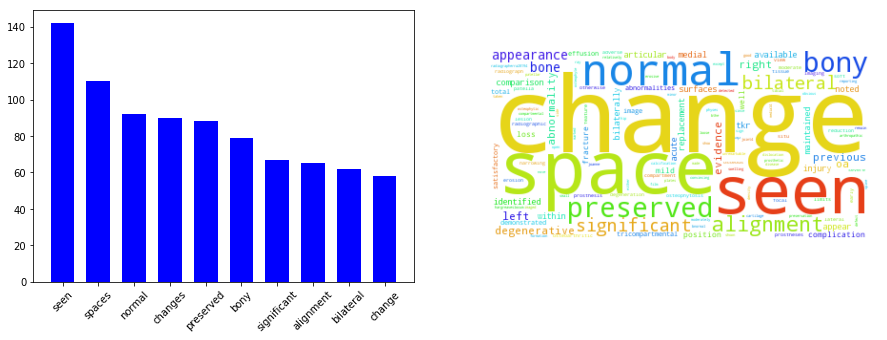

In [15]:
%matplotlib inline
#Visualise clusters
mystoplist = [':', '.', ',', 'knee', 'knees', 'xr', 'joint', 'joints']
stoplist = mystoplist + stopwords.words('english')

visualise_word_clusters2(clusters_is_cl, stoplist)

In [17]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(clusters_is_cl['cluster1'])

{   u'RJ109659609': u'. knees , 2 views , . distal femoral , proximal tibial epiphysiodesis plates bilaterally appear unchanged position . hardware appears intact physes bilaterally appears similar prior . bowing bilateral distal femora noted .',
    u'RJ109660025': u'. uimaging acquired orthopaedic review . uleft knee . previous imaging available . tricompartment degenerative change notable near complete loss medial joint space subchondral sclerosis osteophyte formation .',
    u'RJ109660039': u'. imaging acquired left knee . left-sided total hip replacement situ . radiographically evidence periprosthetic fracture loosening . radiopaque change appearances . please see imaging alignment healing .',
    u'RJ109662083': u'. moderately severe tricompartmental degenerative change right less marked moderate degernative change left . bilaterally slight lateral subluxation tibia respect femora , marked right .',
    u'RJ109662147': u'. mild tricompartmental degenerative changes knees fairly w